In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import xarray as xr
import gsw
from mocsy import mocsy
import cmocean.cm as cm
from matplotlib import colors
from salishsea_tools import viz_tools

Define Month

In [36]:
month_idxs = {
  'January': 0,
  'February': 1,
  'March': 2,
  'April': 3,
  'May': 4,
  'June': 5,
  'July': 6,
  'August': 7,
  'September': 8,
  'October': 9,
  'November': 10,
  'December': 11,
}

month = 'August'
month_idx = month_idxs[month]

In [3]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
# the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
tmask = 1 - mesh.tmask[0]

coastline_mask = np.loadtxt('coastline_5m.csv', delimiter=',')

In [4]:
def get_xyvals(array):
    valid_points = ~np.isnan(array)
    y, x = np.where(valid_points)  # Get coordinates of valid points
    values = array[valid_points]  # Get the actual values
    return x, y, values

In [5]:
def mocsy_simp(ii, ij, ji, jj, salinity_ds, temp_ds, TA_ds, DIC_ds):
    Tinsitu = np.array(gsw.t_from_CT(salinity_ds, temp_ds, 0))
    Spsu = 35/35.16504 * np.array(salinity_ds)
    TA = np.array(TA_ds)/1000.
    DIC = np.array(DIC_ds)/1000.

    ones = np.ones_like(Spsu.flatten())

    response_tup = mocsy.mvars(temp=Tinsitu.flatten(), sal=Spsu.flatten(), alk=TA.flatten(), 
                           dic=DIC.flatten(), 
                       sil=0.*ones, phos=0.*ones, patm=0.*ones, depth=0.*ones, lat=0.*ones, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

    return pH, OmegaA

In [6]:
phys_mon = xr.open_dataset('phys_clim_2016_2023.nc')
chem_mon = xr.open_dataset('chem_clim_2016_2023.nc')

In [15]:
salinity = np.ma.masked_array(phys_mon.isel(month=month_idx).vosaline.to_numpy(), mask=coastline_mask)
temperature = np.ma.masked_array(phys_mon.isel(month=month_idx).votemper.to_numpy(), mask=coastline_mask)
TA = np.ma.masked_array(chem_mon.isel(month=month_idx).total_alkalinity.to_numpy(), mask=coastline_mask)
DIC = np.ma.masked_array(chem_mon.isel(month=month_idx).dissolved_inorganic_carbon.to_numpy(), mask=coastline_mask)

salinity_flat = salinity.flatten()
temperature_flat = temperature.flatten()
TA_flat = TA.flatten()
DIC_flat = DIC.flatten()

In [16]:
ph_flat, omega_flat = mocsy_simp(0, 898, 0, 398, salinity_flat, temperature_flat, TA_flat, DIC_flat)

In [17]:
ph_flat = np.ma.masked_array(ph_flat, mask=coastline_mask)
omega_flat = np.ma.masked_array(omega_flat, mask=coastline_mask)

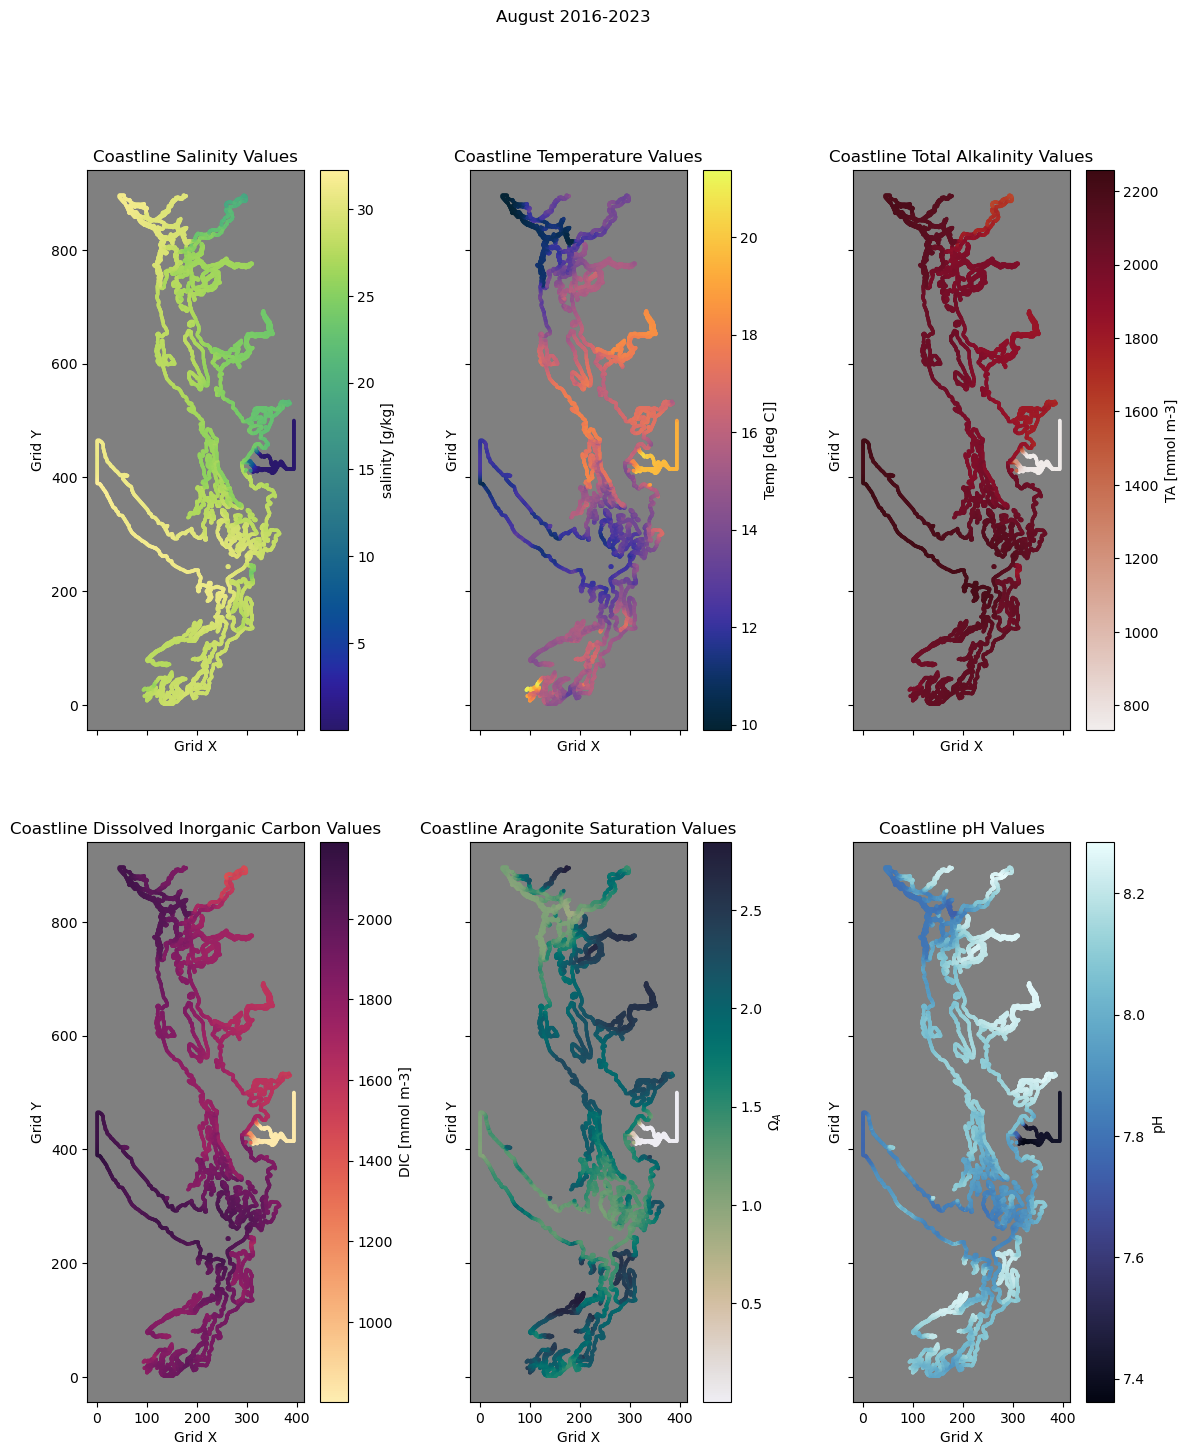

In [37]:
fig, axs = plt.subplots(2,3, figsize = (14,16), sharex=True, sharey=True)
fig.suptitle('{} 2016-2023'.format(month))

# salinity
x, y, salinity_vals = get_xyvals(salinity_flat.reshape(898, 398))
points = axs[0,0].scatter(x, y, c=salinity_vals, cmap=cm.haline, s=2)
axs[0,0].set_title('Coastline Salinity Values')
axs[0,0].set_xlabel('Grid X')
axs[0,0].set_ylabel('Grid Y')
fig.colorbar(points, ax=axs[0,0], label='salinity [g/kg]')
axs[0,0].set_facecolor('grey')
viz_tools.set_aspect(axs[0,0]);

# temperature
x, y, temperature_vals = get_xyvals(temperature_flat.reshape(898, 398))
points = axs[0,1].scatter(x, y, c=temperature_vals, cmap=cm.thermal, s=2)
axs[0,1].set_title('Coastline Temperature Values')
axs[0,1].set_xlabel('Grid X')
axs[0,1].set_ylabel('Grid Y')
fig.colorbar(points, ax=axs[0,1], label='Temp [deg C]]')
axs[0,1].set_facecolor('grey')
viz_tools.set_aspect(axs[0,1]);

# total alkalinity
x, y, TA_vals = get_xyvals(TA_flat.reshape(898, 398))
points = axs[0,2].scatter(x, y, c=TA_vals, cmap=cm.amp, s=2)
axs[0,2].set_title('Coastline Total Alkalinity Values')
axs[0,2].set_xlabel('Grid X')
axs[0,2].set_ylabel('Grid Y')
fig.colorbar(points, ax=axs[0,2], label='TA [mmol m-3]')
axs[0,2].set_facecolor('grey')
viz_tools.set_aspect(axs[0,2]);

# dissolved inorganic carbon
x, y, DIC_vals = get_xyvals(DIC_flat.reshape(898, 398))
points = axs[1,0].scatter(x, y, c=DIC_vals, cmap=cm.matter, s=2)
axs[1,0].set_title('Coastline Dissolved Inorganic Carbon Values')
axs[1,0].set_xlabel('Grid X')
axs[1,0].set_ylabel('Grid Y')
fig.colorbar(points, ax=axs[1,0], label='DIC [mmol m-3]')
axs[1,0].set_facecolor('grey')
viz_tools.set_aspect(axs[1,0]);

# aragonite saturation
x, y, omegaA_vals = get_xyvals(omega_flat.reshape(898, 398))
points = axs[1,1].scatter(x, y, c=omegaA_vals, cmap=cm.rain, s=2)
axs[1,1].set_title('Coastline Aragonite Saturation Values')
axs[1,1].set_xlabel('Grid X')
axs[1,1].set_ylabel('Grid Y')
fig.colorbar(points, ax=axs[1,1], label=r'$\Omega_A$')
axs[1,1].set_facecolor('grey')
viz_tools.set_aspect(axs[1,1]);

# pH
x, y, ph_vals = get_xyvals(ph_flat.reshape(898, 398))
points = axs[1,2].scatter(x, y, c=ph_vals, cmap=cm.ice, s=2)
axs[1,2].set_title('Coastline pH Values')
axs[1,2].set_xlabel('Grid X')
axs[1,2].set_ylabel('Grid Y')
fig.colorbar(points, ax=axs[1,2], label=r'pH')
axs[1,2].set_facecolor('grey')
viz_tools.set_aspect(axs[1,2]);

## Clustering on Temperature, Salinity, and pH with equal weights

In [19]:
# Combine the flattened arrays into a single dataset
mask = np.isnan(salinity.filled(np.nan))
data = np.vstack((salinity_flat.filled(np.nan), temperature_flat.filled(np.nan), ph_flat.filled(np.nan))).T
data_clean = data[~np.isnan(data).any(axis=1)]

# Normalize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_clean)

# Apply K-Means clustering
n_clusters = 6  # Set the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters = kmeans.fit_predict(data_normalized)

clusters_2d = np.full(salinity.shape, np.nan)
clusters_2d[~mask] = clusters

In [20]:
cmap = plt.cm.rainbow
norm = colors.BoundaryNorm(np.arange(-0.5, n_clusters, 1), cmap.N)
cluster_colors = cmap(norm(np.arange(6)))

In [21]:
salinity_vals_only = salinity_flat.filled(np.nan)[~mask.flatten()]
temperature_vals_only = temperature_flat.filled(np.nan)[~mask.flatten()]
ph_vals_only = ph_flat.filled(np.nan)[~mask.flatten()]

param_vals = [salinity_vals_only, temperature_vals_only, ph_vals_only]

In [22]:
salinity_means = np.zeros(n_clusters)
temperature_means = np.zeros(n_clusters)
ph_means = np.zeros(n_clusters)

sal_as_clusters = list()
temp_as_clusters = list()
ph_as_clusters = list()

for i in range(n_clusters):
    sal_mean = salinity_vals_only[clusters == i].mean()
    salinity_means[i] = sal_mean

    temp_mean = temperature_vals_only[clusters == i].mean()
    temperature_means[i] = temp_mean

    ph_mean = ph_vals_only[clusters == i].mean()
    ph_means[i] = ph_mean

    sal_as_clusters.append(salinity_vals_only[clusters == i])
    temp_as_clusters.append(temperature_vals_only[clusters == i])
    ph_as_clusters.append(ph_vals_only[clusters == i])

list_of_params = [sal_as_clusters, temp_as_clusters, ph_as_clusters]

## Cluster Map

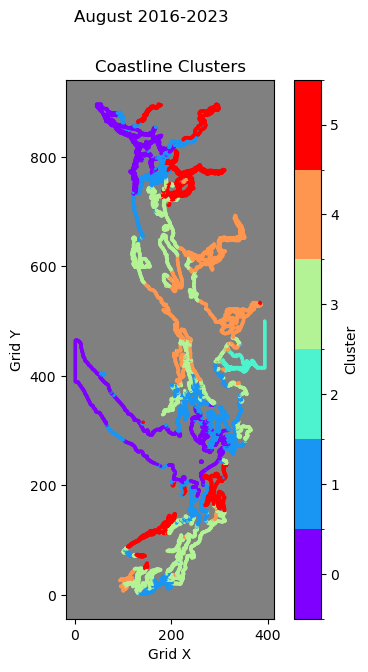

In [38]:
x, y, cluster_vals = get_xyvals(clusters_2d)

fig, ax = plt.subplots(1,1, figsize = (5,7))
fig.suptitle('{} 2016-2023'.format(month))

points = ax.scatter(x, y, c=cluster_vals, cmap=cmap, norm=norm, s=2)
ax.set_title('Coastline Clusters')
ax.set_xlabel('Grid X')
ax.set_ylabel('Grid Y')
fig.colorbar(points, ticks=np.linspace(0, n_clusters-1, n_clusters), label='Cluster')
ax.set_facecolor('grey')
viz_tools.set_aspect(ax);

## Property Diagrams

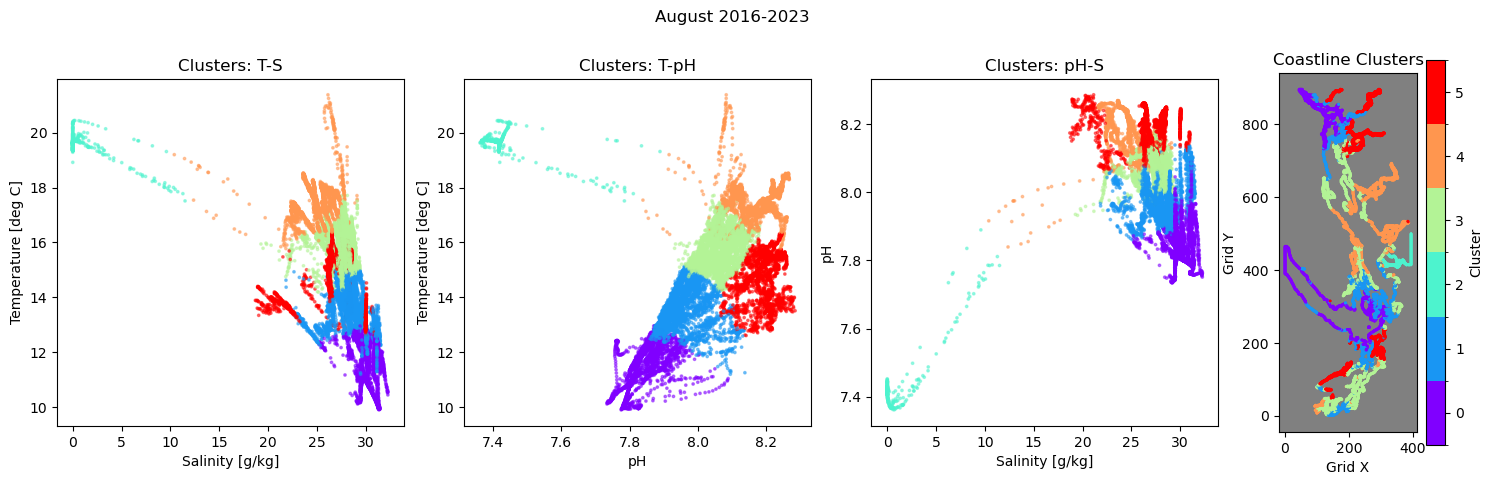

In [39]:
fig, ax = plt.subplots(1,4, figsize = (18,5), gridspec_kw={'width_ratios': [2,2,2,1]})
fig.suptitle('{} 2016-2023'.format(month))

points = ax[0].scatter(salinity_vals_only, temperature_vals_only, c=cluster_vals, cmap=cmap, norm=norm, s=3, alpha=0.5)
ax[0].set_title('Clusters: T-S')
ax[0].set_xlabel('Salinity [g/kg]')
ax[0].set_ylabel('Temperature [deg C]')
ax[0].set_box_aspect(1)

points = ax[1].scatter(ph_vals_only, temperature_vals_only, c=cluster_vals, cmap=cmap, norm=norm, s=3, alpha=0.5)
ax[1].set_title('Clusters: T-pH')
ax[1].set_xlabel('pH')
ax[1].set_ylabel('Temperature [deg C]')
ax[1].set_box_aspect(1)

points = ax[2].scatter(salinity_vals_only, ph_vals_only, c=cluster_vals, cmap=cmap, norm=norm, s=3, alpha=0.5)
ax[2].set_title('Clusters: pH-S')
ax[2].set_xlabel('Salinity [g/kg]')
ax[2].set_ylabel('pH')
ax[2].set_box_aspect(1)

x, y, cluster_vals = get_xyvals(clusters_2d)
points = ax[3].scatter(x, y, c=cluster_vals, cmap=cmap, norm=norm, s=1)
ax[3].set_title('Coastline Clusters')
ax[3].set_xlabel('Grid X')
ax[3].set_ylabel('Grid Y')
fig.colorbar(points, ticks=np.linspace(0, n_clusters-1, n_clusters), label='Cluster')
ax[3].set_facecolor('grey')
viz_tools.set_aspect(ax[3]);

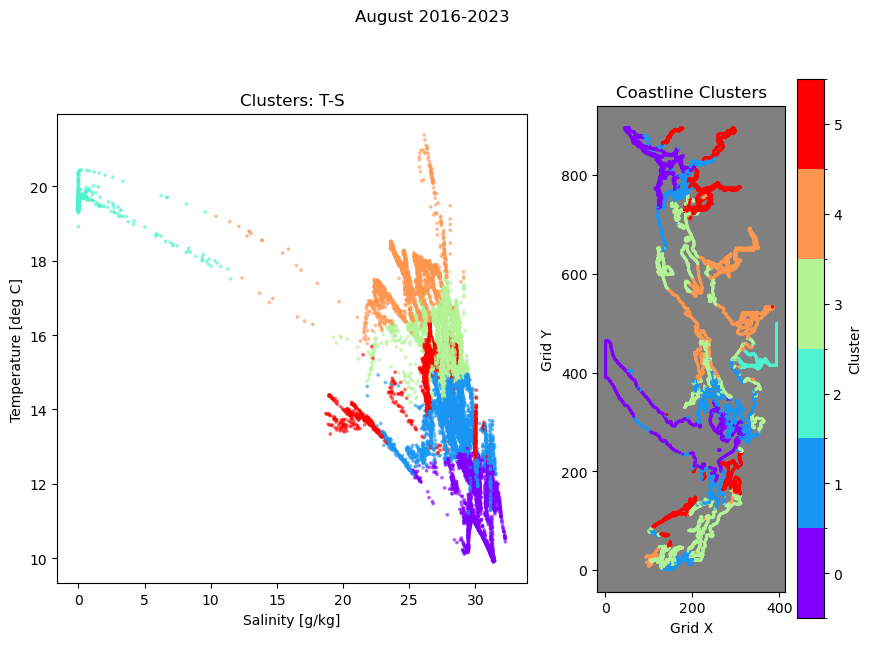

In [45]:
fig, ax = plt.subplots(1,2, figsize = (10,7), gridspec_kw={'width_ratios': [2,1]})
fig.suptitle('{} 2016-2023'.format(month))

points = ax[0].scatter(salinity_vals_only, temperature_vals_only, c=cluster_vals, cmap=cmap, norm=norm, s=3, alpha=0.5)
ax[0].set_title('Clusters: T-S')
ax[0].set_xlabel('Salinity [g/kg]')
ax[0].set_ylabel('Temperature [deg C]')
ax[0].set_box_aspect(1)

x, y, cluster_vals = get_xyvals(clusters_2d)
points = ax[1].scatter(x, y, c=cluster_vals, cmap=cmap, norm=norm, s=1)
ax[1].set_title('Coastline Clusters')
ax[1].set_xlabel('Grid X')
ax[1].set_ylabel('Grid Y')
fig.colorbar(points, ticks=np.linspace(0, n_clusters-1, n_clusters), label='Cluster')
ax[1].set_facecolor('grey')
viz_tools.set_aspect(ax[1]);

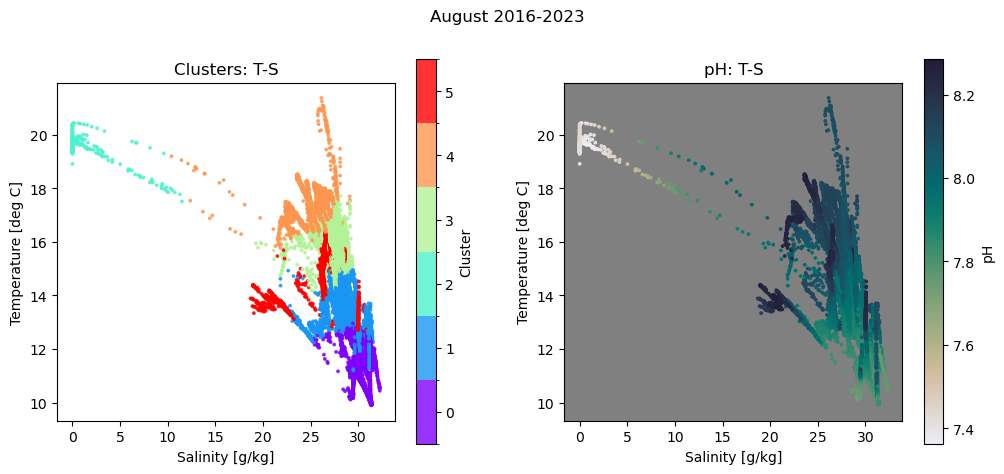

In [40]:
fig, ax = plt.subplots(1,2, figsize = (12,5), gridspec_kw={'width_ratios': [1,1]})
fig.suptitle('{} 2016-2023'.format(month))

points = ax[0].scatter(salinity_vals_only, temperature_vals_only, c=cluster_vals, cmap=cmap, norm=norm, s=3, alpha=0.8)
ax[0].set_title('Clusters: T-S')
ax[0].set_xlabel('Salinity [g/kg]')
ax[0].set_ylabel('Temperature [deg C]')
ax[0].set_box_aspect(1)
fig.colorbar(points, ax=ax[0], ticks=np.linspace(0, n_clusters-1, n_clusters), label='Cluster')

points = ax[1].scatter(salinity_vals_only, temperature_vals_only, c=ph_vals_only, cmap=cm.rain, s=3)
ax[1].set_title('pH: T-S')
ax[1].set_xlabel('Salinity [g/kg]')
ax[1].set_ylabel('Temperature [deg C]')
ax[1].set_box_aspect(1)
ax[1].set_facecolor('grey')
fig.colorbar(points, ax=ax[1], label='pH')

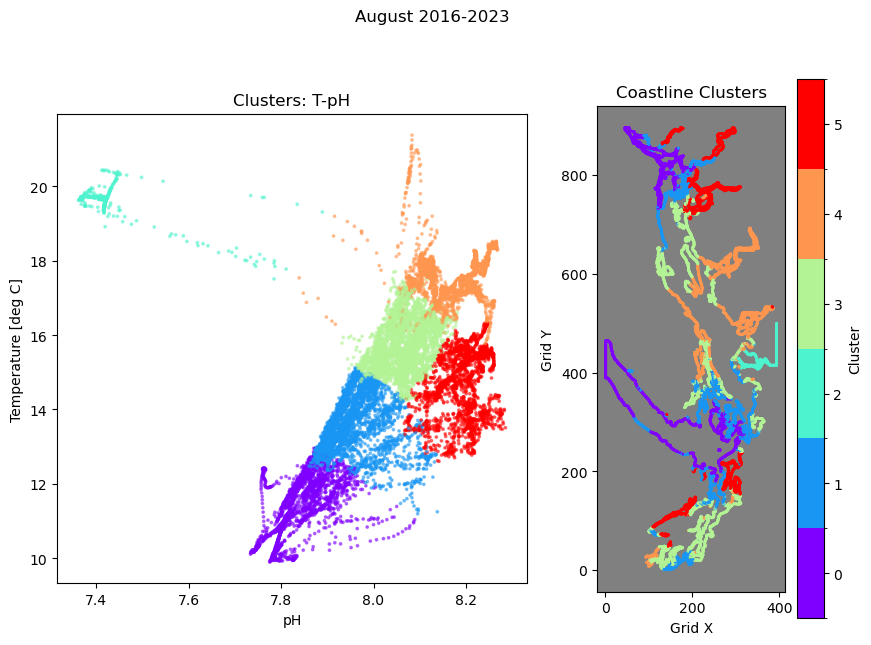

In [47]:
fig, ax = plt.subplots(1,2, figsize = (10,7), gridspec_kw={'width_ratios': [2,1]})
fig.suptitle('{} 2016-2023'.format(month))

points = ax[0].scatter(ph_vals_only, temperature_vals_only, c=cluster_vals, cmap=cmap, norm=norm, s=3, alpha=0.5)
ax[0].set_title('Clusters: T-pH')
ax[0].set_xlabel('pH')
ax[0].set_ylabel('Temperature [deg C]')
ax[0].set_box_aspect(1)

x, y, cluster_vals = get_xyvals(clusters_2d)
points = ax[1].scatter(x, y, c=cluster_vals, cmap=cmap, norm=norm, s=1)
ax[1].set_title('Coastline Clusters')
ax[1].set_xlabel('Grid X')
ax[1].set_ylabel('Grid Y')
fig.colorbar(points, ticks=np.linspace(0, n_clusters-1, n_clusters), label='Cluster')
ax[1].set_facecolor('grey')
viz_tools.set_aspect(ax[1]);

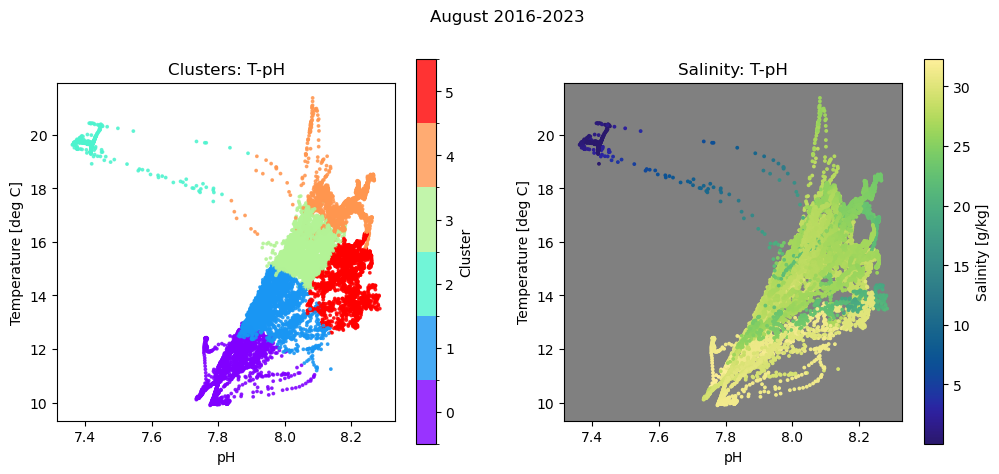

In [41]:
fig, ax = plt.subplots(1,2, figsize = (12,5), gridspec_kw={'width_ratios': [1,1]})
fig.suptitle('{} 2016-2023'.format(month))

points = ax[0].scatter(ph_vals_only, temperature_vals_only, c=cluster_vals, cmap=cmap, norm=norm, s=3, alpha=0.8)
ax[0].set_title('Clusters: T-pH')
ax[0].set_xlabel('pH')
ax[0].set_ylabel('Temperature [deg C]')
ax[0].set_box_aspect(1)
fig.colorbar(points, ax=ax[0], ticks=np.linspace(0, n_clusters-1, n_clusters), label='Cluster')

points = ax[1].scatter(ph_vals_only, temperature_vals_only, c=salinity_vals_only, cmap=cm.haline, s=3)
ax[1].set_title('Salinity: T-pH')
ax[1].set_xlabel('pH')
ax[1].set_ylabel('Temperature [deg C]')
ax[1].set_box_aspect(1)
ax[1].set_facecolor('grey')
fig.colorbar(points, ax=ax[1], label='Salinity [g/kg]')

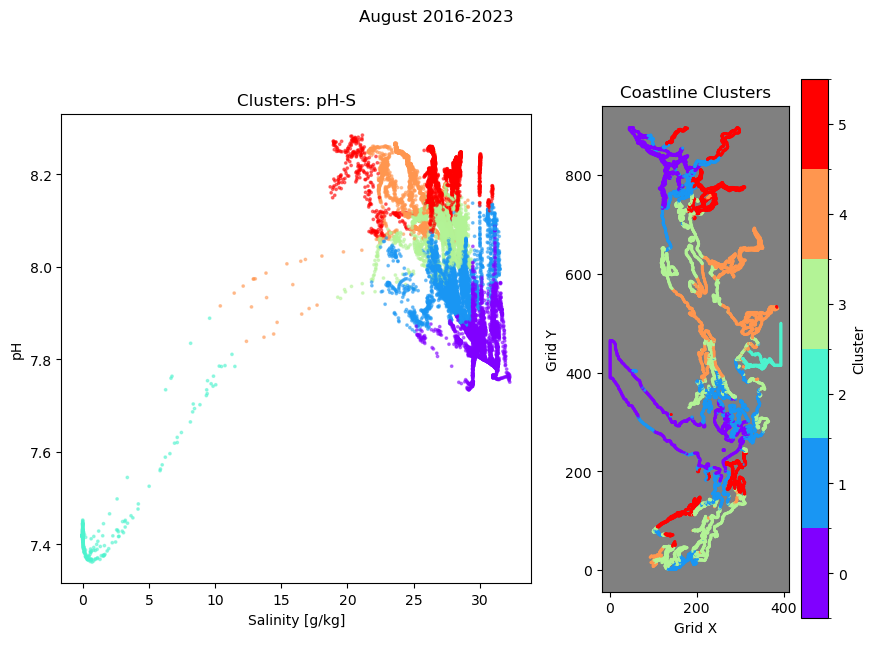

In [46]:
fig, ax = plt.subplots(1,2, figsize = (10,7), gridspec_kw={'width_ratios': [2,1]})
fig.suptitle('{} 2016-2023'.format(month))

points = ax[0].scatter(salinity_vals_only, ph_vals_only, c=cluster_vals, cmap=cmap, norm=norm, s=3, alpha=0.5)
ax[0].set_title('Clusters: pH-S')
ax[0].set_xlabel('Salinity [g/kg]')
ax[0].set_ylabel('pH')
ax[0].set_box_aspect(1)

x, y, cluster_vals = get_xyvals(clusters_2d)
points = ax[1].scatter(x, y, c=cluster_vals, cmap=cmap, norm=norm, s=1)
ax[1].set_title('Coastline Clusters')
ax[1].set_xlabel('Grid X')
ax[1].set_ylabel('Grid Y')
fig.colorbar(points, ticks=np.linspace(0, n_clusters-1, n_clusters), label='Cluster')
ax[1].set_facecolor('grey')
viz_tools.set_aspect(ax[1]);

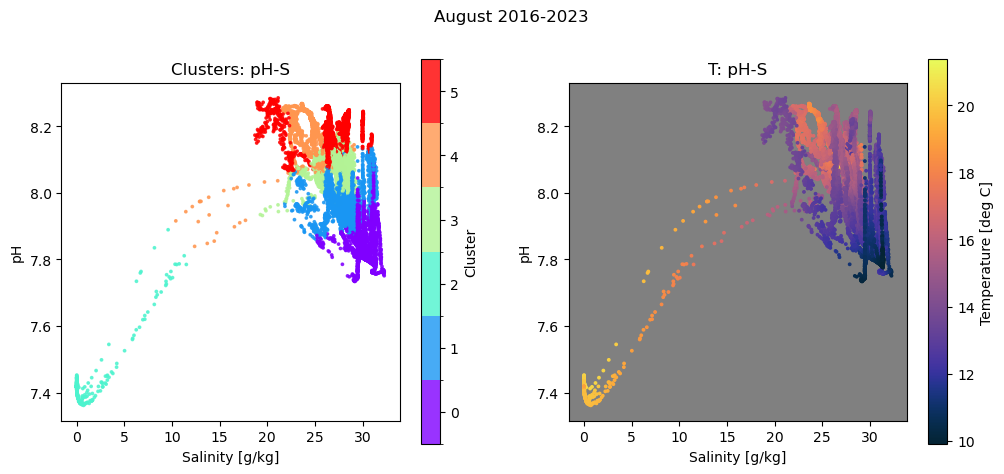

In [42]:
fig, ax = plt.subplots(1,2, figsize = (12,5), gridspec_kw={'width_ratios': [1,1]})
fig.suptitle('{} 2016-2023'.format(month))

points = ax[0].scatter(salinity_vals_only, ph_vals_only, c=cluster_vals, cmap=cmap, norm=norm, s=3, alpha=0.8)
ax[0].set_title('Clusters: pH-S')
ax[0].set_xlabel('Salinity [g/kg]')
ax[0].set_ylabel('pH')
ax[0].set_box_aspect(1)
fig.colorbar(points, ax=ax[0], ticks=np.linspace(0, n_clusters-1, n_clusters), label='Cluster')

points = ax[1].scatter(salinity_vals_only, ph_vals_only, c=temperature_vals_only, cmap=cm.thermal, s=3)
ax[1].set_title('T: pH-S')
ax[1].set_xlabel('Salinity [g/kg]')
ax[1].set_ylabel('pH')
ax[1].set_box_aspect(1)
ax[1].set_facecolor('grey')
fig.colorbar(points, ax=ax[1], label='Temperature [deg C]')

## Box plots

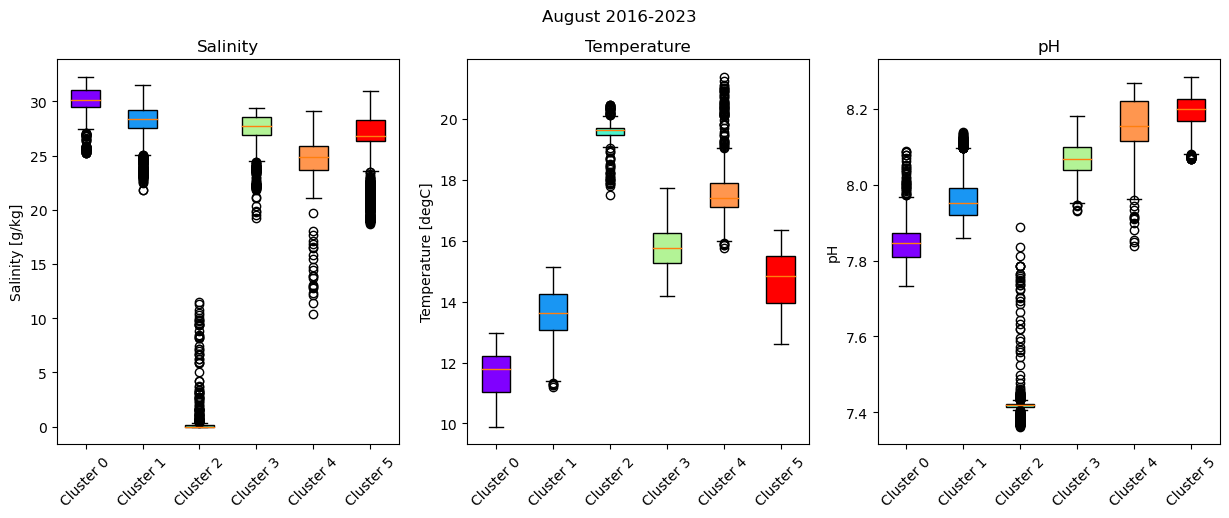

In [43]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('{} 2016-2023'.format(month))

param_titles = ['Salinity', 'Temperature', 'pH']
param_units = ['Salinity [g/kg]', 'Temperature [degC]', 'pH']

for i in range(3):
    boxplot = ax[i].boxplot(list_of_params[i], patch_artist=True)

    ax[i].set_title(param_titles[i])
    ax[i].set_ylabel(param_units[i])
    ax[i].set_xticks(range(1, n_clusters + 1))
    ax[i].set_xticklabels([f'Cluster {j}' for j in range(0, n_clusters)], rotation=45)

    for box, color in zip(boxplot['boxes'], cluster_colors):
        box.set_facecolor(color)

## Summary plot

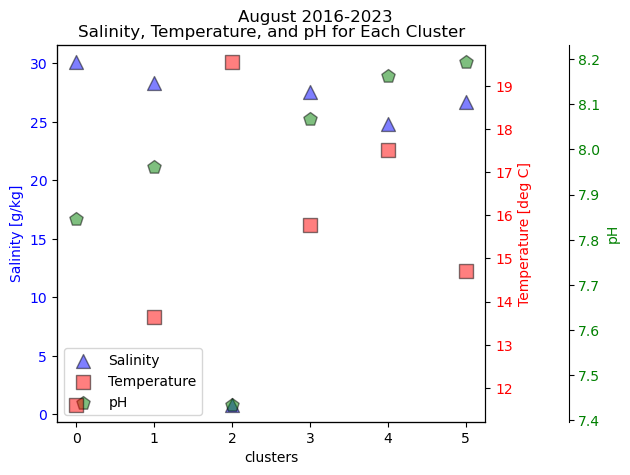

In [44]:
fig, ax1 = plt.subplots()
fig.suptitle('{} 2016-2023'.format(month))

# salinity
scatter1 = ax1.scatter(range(n_clusters), salinity_means, color='b', label='salinity', marker='^', edgecolor='k', s=100, alpha=0.5)
ax1.set_xlabel('clusters')
ax1.set_ylabel('Salinity [g/kg]', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# temperature
ax2 = ax1.twinx()
scatter2 = ax2.scatter(range(n_clusters), temperature_means, color='r', label='temperature', marker='s', edgecolor='k', s=100, alpha=0.5)
ax2.set_ylabel('Temperature [deg C]', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# ph
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # move third y-axis outward
scatter3 = ax3.scatter(range(n_clusters), ph_means, color='g', label='ph', marker='p', edgecolor='k', s=100, alpha=0.5)
ax3.set_ylabel('pH', color='g')
ax3.tick_params(axis='y', labelcolor='g')

lines = [scatter1, scatter2, scatter3]
labels = ['Salinity', 'Temperature', 'pH']
ax1.legend(lines, labels)

fig.tight_layout()  # adjust layout to avoid overlap
plt.title('Salinity, Temperature, and pH for Each Cluster')
plt.show()